#### Libraries

In [1]:
import copy, time
import random
import pdb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal

In [2]:
from IPython import display
matplotlib.rcParams['figure.figsize'] = [26,8]

#### Generic Utils 

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value. 
       Also stores a rolling average of size roll_len."""
    def __init__(self, roll_len=100):
        self.reset()
        self.roll_len = roll_len
        self.roll = []

    def reset(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0; self.roll = []; self.roll_avg = 0

    def update(self, val, n=1):
        self.val = val; self.sum += val * n; self.count += n
        self.avg = self.sum / self.count
        self.roll = (self.roll + [val] * n)[-self.roll_len:]
        self.roll_avg = sum(self.roll) / len(self.roll)
        
def check(val, msg):
    '''Checks whether val is nan or inf and prints msg if True'''
    if (val * 0 != 0): print(msg); pdb.set_trace()
        
def to_numpy(t):
    '''PyTorch tensor to numpy array'''
    return t.detach().to('cpu').numpy()

#### Model

In [48]:
class FlatNet(nn.Module):
    def __init__(self, layers, prior):
        super(FlatNet, self).__init__()
        self.layers = layers
        self.W_ids = [] # will hold indices of weights
        self.B_ids = [] # will hold incides of biases
        self.prior = prior
        
        # Count total number of parameters and split into weights, biases
        ptr = 0 # current parameter
        for i in range(len(layers)-1):
            w_size = layers[i] * layers[i+1]
            b_size = layers[i+1]
            self.W_ids.append([ptr, ptr + w_size])
            self.B_ids.append([ptr + w_size, ptr + w_size + b_size])
            ptr += w_size + b_size
        self.N = ptr # total number of parameters    
        
        # Create and initialize parameters
        self.lambdas = nn.Parameter(torch.zeros(2 * self.N))
        self.lambdas.data[:self.N].fill_(0.00) #  = prior.rsample().data # means
        self.lambdas.data[self.N:].fill_(1.21) #  = prior.rsample().data # log standard deviations
                
    def get_means(self):
        return self.lambdas[:self.N]

    def get_stdvs(self):
        return torch.exp(model.lambdas[self.N:]) # F.softplus(model.lambdas[self.N:])

    def forward(self, x, sample):
        '''Unroll network and forward pass'''
        dim = 1
        for i in range(len(self.W_ids)):
            w = sample[self.W_ids[i][0]:self.W_ids[i][1]].reshape(dim, -1)
            b = sample[self.B_ids[i][0]:self.B_ids[i][1]].reshape(1,-1)
            dim = w.shape[1]
            
            x = x @ w + b
            x = torch.exp(-x*x) if i != len(self.W_ids)-1 else x
            
        return x
    
class GaussianMixture(torch.distributions.Distribution):
    def __init__(self, pi, m1, m2, s1, s2):
        '''A mixture of 2 Gaussians with means m1, m2 and standard
        deviations s1, s2.'''
        self.g1 = Normal(m1, s1) #torch.exp(torch.FloatTensor([s1])))
        self.g2 = Normal(m2, s2) #torch.exp(torch.FloatTensor([s2])))
        self.pi = pi
    
    def log_prob(self, y):
        return self.pi * self.g1.log_prob(y) + (1-self.pi) * self.g2.log_prob(y)
    
    def rsample(self):
        return self.pi * self.g1.rsample() + (1-self.pi) * self.g2.rsample()

In [42]:
def BBB(x, y, model, optimizer, num_samples=1, epochs=int(1e5), seed=None, print_every=500):
    '''Performs black-box variational inference'''
    torch.manual_seed(seed if seed else random.randint(0,1000))
        
    # Track ELBO statistics
    elbo_meter = AverageMeter(100)
    elbo_hist = []
    
    # Prior
    p_dist = model.prior #Normal(torch.zeros(model.N), 3.16 * torch.ones(model.N))  #model.prior
    
    for ix_e in range(epochs):
        for ix_s in range(num_samples):
            
            # Distributions
            q_dist = Normal(model.get_means(), model.get_stdvs())

            # Sample weights
            sample = q_dist.rsample()
                        
            # Likelihood
            y_hat = model.forward(x, sample)
            log_l = Normal(y_hat.squeeze(), 0.1 * torch.ones(6)).log_prob(y.squeeze()).sum()
            
            # Regularization
            log_p = p_dist.log_prob(sample).sum()
            log_q = q_dist.log_prob(sample).sum()
            
            # ELBO = log likelihood + log p - log q
            elbo = (log_l + log_p - log_q).squeeze()
            loss = - elbo / num_samples
            
            # Store gradients
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            
            # Update ELBO statistics
            elbo_meter.update(elbo.item())
            elbo_hist.append(elbo.item())
        
        # Step gradient
        optimizer.step()

        # Print statistics
        if print_every > 0 and ix_e % print_every == 10: 
            print('{:5d} | ELBO {:6.0f} | Rolling: {:6.0f}'.format(
                ix_e, elbo_meter.avg, elbo_meter.roll_avg))

    return model, elbo_meter.roll_avg, elbo_hist

In [49]:
# #####################################
# ###### Sampling from the prior ######
# #####################################

# # Data and prediction range
# X = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1)
# Y = - X*X*X*X + 3*X*X + 1
# X_range = torch.arange(-5,5,0.05).reshape(-1,1)

# # Hyperparameters
# grid_parameters = [[0.20, 1.00, 2.5], [0.50, 1.00, 2.5], [0.80, 1.00, 2.5],
#                    [0.20, 0.10, 2.5], [0.50, 0.10, 2.5], [0.80, 0.10, 2.5],
#                    [0.20, 0.01, 0.5], [0.50, 0.01, 0.5], [0.80, 0.01, 0.5],]

# # Loop and plot
# for i, (pi, s1, s2) in enumerate(grid_parameters):
#     plt.tight_layout()
#     plt.subplot(3,3,i+1)
#     for _ in range(15):
        
#         # Model and sampling
#         prior = GaussianMixture(pi, torch.zeros(31), torch.zeros(31), torch.ones(31)*s1, torch.ones(31)*s2)
#         model = FlatNet([1,10,1], prior)
#         optimizer = torch.optim.SGD([model.lambdas], lr=2e-4)
#         model, elbo, hist = BBB(X, Y, model, optimizer, print_every=4000, epochs=int(0))

#         # Plot samples from prior distribution
#         pred = model(X_range, Normal(model.get_means(), model.get_stdvs()).sample())
#         plt.plot(to_numpy(X_range), to_numpy(pred))
#         plt.gca().set_title('Mixed Gaussian Prior with π={}, σ1={}, σ2={}'.format(pi, s1, s2))
        
# plt.xlim([-5,5])
# plt.show()

In [50]:
#########################################
###### Sampling from the posterior ######
#########################################

# Model and sampling
pi, s1, s2 = 0.1, 3.0, 5.0
prior = GaussianMixture(pi, torch.zeros(31), torch.zeros(31), s1, s2)
model = FlatNet([1,10,1], prior)
optimizer = torch.optim.SGD([model.lambdas], lr=1e-4)
model, elbo, hist = BBB(X, Y, model, optimizer, print_every=4000, epochs=int(3e4))
print('-------- Transitioning to 1e-5')
optimizer = torch.optim.SGD([model.lambdas], lr=1e-5)
model, elbo, hist = BBB(X, Y, model, optimizer, print_every=4000, epochs=int(3e4))


   10 | ELBO  -7711 | Rolling:  -7711
 4010 | ELBO  -1298 | Rolling:   -505
 8010 | ELBO   -837 | Rolling:   -326
12010 | ELBO   -673 | Rolling:   -338
16010 | ELBO   -590 | Rolling:   -340
20010 | ELBO   -541 | Rolling:   -339
24010 | ELBO   -508 | Rolling:   -364
28010 | ELBO   -484 | Rolling:   -331
-------- Transitioning to 1e-5
   10 | ELBO   -279 | Rolling:   -279
 4010 | ELBO   -168 | Rolling:   -149
 8010 | ELBO   -152 | Rolling:   -125
12010 | ELBO   -140 | Rolling:   -111
16010 | ELBO   -131 | Rolling:    -97
20010 | ELBO   -123 | Rolling:    -89
24010 | ELBO   -117 | Rolling:    -83
28010 | ELBO   -112 | Rolling:    -80


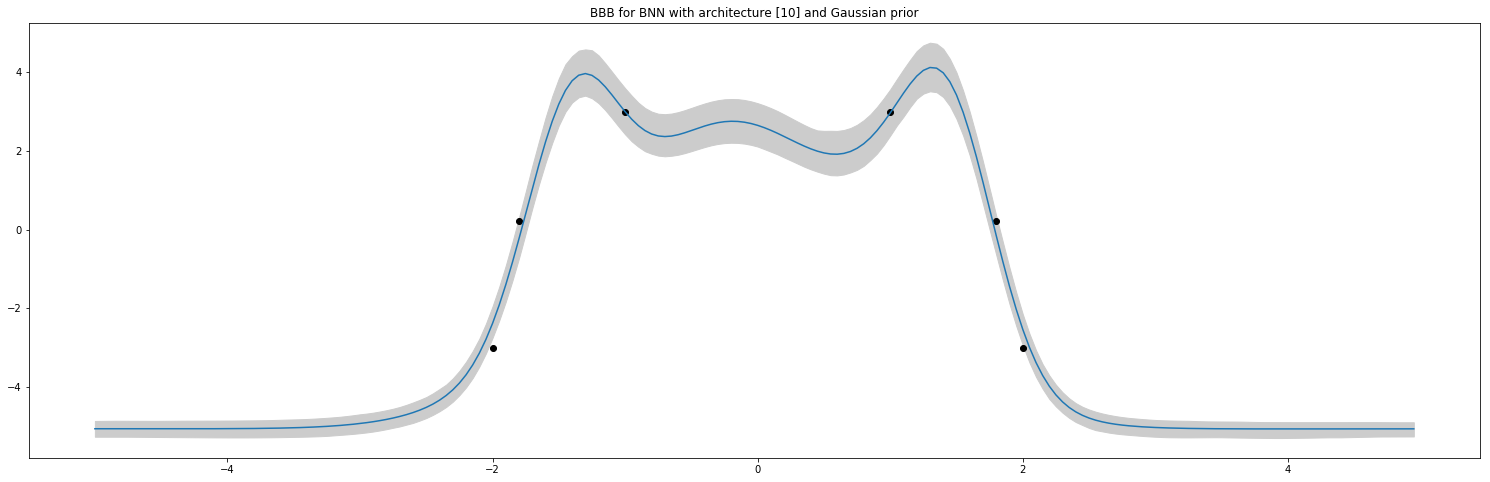

In [51]:
# Sample from distribution over networks
model = best_model
preds = [model(X_range, Normal(model.get_means(), model.get_stdvs()).sample()) for _ in range(1000)]
preds = np.concatenate(preds, axis=1)
bounds = (np.sort(preds, axis=1)[:, 5], np.sort(preds, axis=1)[:,-5])
mean = np.mean(preds, axis=1)

# Plot
plt.gca().set_title('BBB for BNN with architecture [10] and Gaussian prior')
plt.gca().fill_between(X_range.reshape(-1), bounds[1], bounds[0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')
plt.plot(to_numpy(X_range), mean)
plt.show() # plt.axis([-5,5,-8,8])

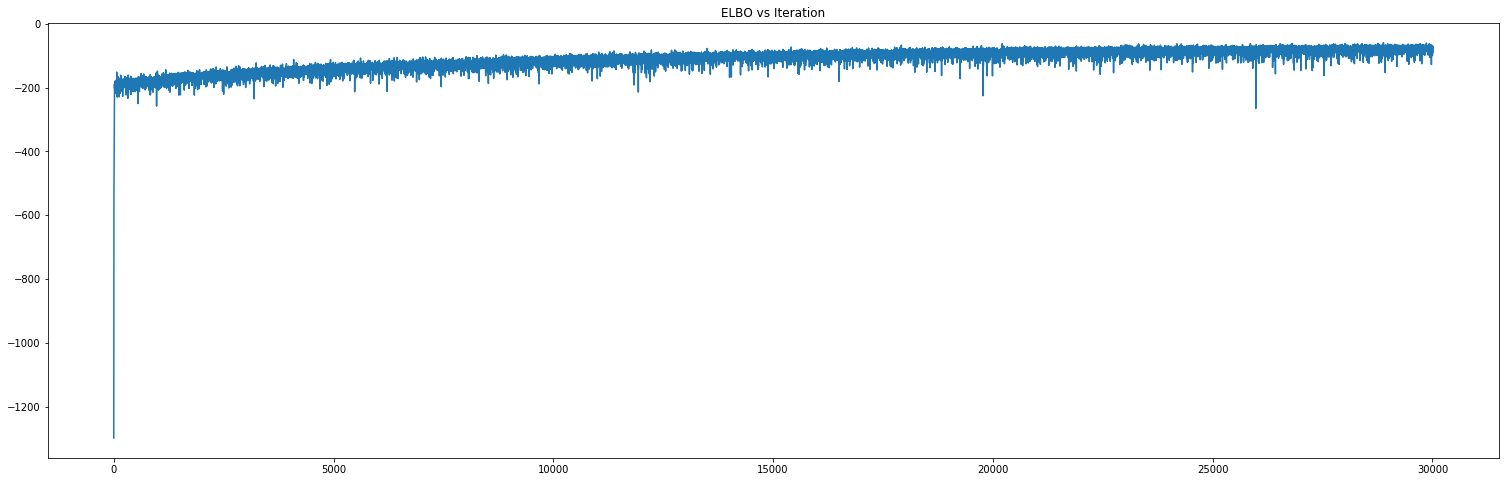

In [57]:
plt.title('ELBO vs Iteration')
plt.plot([-1298, -837, -673, -590, -541, -508, -484] +  hist)

In [ ]:
# [-7711,-1298, -837, -673, -590, -541, -508, -484]